# Training Unsupervised Models
## 04_unsupervised_model_learning

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 28/09/2025   | Adrienne | Update | Creating models |
| 05/10/2025 | Adrienne | Update | Created baseline model with KMeans |
| 07.10.2025 | Adrienne | Update | Added code for wordcloud visualization |

# Content

* [Introduction](#introduction)

In [297]:
import pandas as pd
import numpy as np

# train test split
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

#unsupervised learning methods
# Feature agglomeration uses agglomerative(or hierarchical) clustering to group similar features, so it has its own dimensionality reduction technique
from sklearn.cluster import KMeans, AgglomerativeClustering, FeatureAgglomeration, DBSCAN
from sklearn.mixture import GaussianMixture

# dimensionality reduction methods
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE

# model selection
from sklearn.model_selection import GridSearchCV

# model scores
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score
import setuptools
from yellowbrick.cluster import SilhouetteVisualizer

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image


## Load Data

In [298]:
# readin in patient level file label encoded
path = "../data/clean"
df_lab_enc = pd.read_pickle(f"{path}/patient_level_lab_enc.pkl")
df_TD_enc = pd.read_pickle(f"{path}/patient_level_TD_enc.pkl")
df_patient = pd.read_pickle(f"{path}/patient_level.pkl")

In [299]:
# readin icd10 mapper
mapper_path = "../data/mappers"
icd10_mapper = pd.read_pickle(f"{mapper_path}/icd10.pkl")

## Introduction - Model Development

We will create a baseline model using the label encoded patient level file.  Variations on the model will be added and then performance compared.  Initially, we encoded the data using labels, but when running the first Kmeans model, we realized that the missings created by that feature encoding method was not surprisingly giving very poor results.  We then switched to TD-IDF encoding and got much better and useful results.

### Baseline Model - KMeans
Steps: 
- standardize features
- reduce features using PCA
- use Scree plot to find optimal number of components
- create KMeans model
- find optimal number of clusters using Silhouette and Elbow methods
- examine most important feature by principal component
- create graph of clusters with first two principal components
- optimize any model inputs

### Label Encoding

In [171]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_lab_enc)

Dimensionality Reduction using Principal Component Analysis

In [172]:
# Perform PCA
pca = PCA(n_components=12)
X_pca = pca.fit_transform(X_scaled)

# Calculate the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
np.cumsum(explained_variance_ratio)

array([0.32139365, 0.5169153 , 0.61577772, 0.67507509, 0.71502866,
       0.74214979, 0.76503696, 0.78233255, 0.79639411, 0.80854447,
       0.81792515, 0.82567947])

Scree Plot - to Analyze Optimal PCA Components

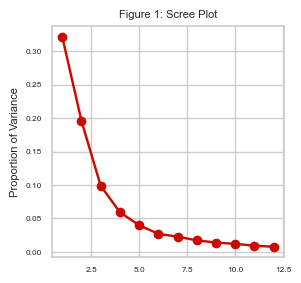

In [174]:
PC_numbers = np.arange(pca.n_components_) + 1

plt.figure(figsize=(3, 3)) 
plt.plot(PC_numbers, 
         explained_variance_ratio, 
         'ro-')
plt.title('Figure 1: Scree Plot', fontsize=8)
plt.ylabel('Proportion of Variance', fontsize=8)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.show()

In [175]:
# kmeans code
kmeans = KMeans(init = 'random', n_clusters=6, n_init=10, random_state = 0) 
km = kmeans.fit(X_pca) 
km.n_iter_
labels = km.labels_
#print(labels)


In [176]:
# add cluster results to dataset
df_lab_enc['cluster'] = labels

/var/folders/h7/vnb5cqf52l31_n7r6zv3j6z80000gn/T/ipykernel_17778/3106083151.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lab_enc['cluster'] = labels


In [177]:
# quick look at cluster values
vals = df_lab_enc['cluster'].value_counts(normalize=True) * 100
pd.DataFrame({
  'cluster': vals
}).head(12)

,cluster
cluster,
5,54.042179
2,26.274165
1,10.369069
0,7.293497
3,1.845343
4,0.175747


In [178]:
# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component i.e. largest absolute value
# using LIST COMPREHENSION HERE
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = df_lab_enc.columns

# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# using LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}
dic

{'PC1': 'category_225_enc',
 'PC2': 'hcpcs_482_enc',
 'PC3': 'hcpcs_392_enc',
 'PC4': 'hcpcs_440_enc',
 'PC5': 'hcpcs_44_enc',
 'PC6': 'hcpcs_484_enc',
 'PC7': 'hcpcs_484_enc',
 'PC8': 'category_27_enc',
 'PC9': 'hcpcs_385_enc',
 'PC10': 'category_17_enc',
 'PC11': 'category_17_enc',
 'PC12': 'hcpcs_413_enc'}

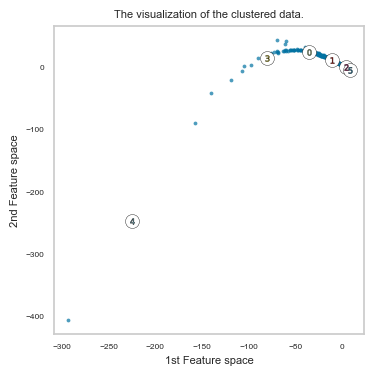

In [179]:
fig, ax = plt.subplots(figsize=(4, 4))
#colors = cm.nipy_spectral(labels.astype(float) / n_clusters)
ax.scatter(
        X_pca[:, 0], X_pca[:, 1], 
        marker=".", 
        s=30, 
        lw=0, 
        alpha=0.7, 
        #c=colors, 
        edgecolor="k"
    )

# Labeling the clusters
centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
ax.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=100,
        edgecolor="k",
    )

for i, c in enumerate(centers):
    ax.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=20, edgecolor="k")
    ax.set_title("The visualization of the clustered data.")
    ax.set_xlabel("1st Feature space")
    ax.set_ylabel("2nd Feature space")
    ax.grid(False)
    

    plt.rcParams['axes.titlesize'] = 8
    plt.rcParams['axes.labelsize'] = 8
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)

plt.show()

#### Finding Optimal Clusters

Silhouette Score

In [180]:
# works for all sklearn unsupervised model evaluation metrics with DBSCAN
score = silhouette_score(X_pca, km.labels_, metric='euclidean')
print('Silhouetter Score: %.3f' % score)

Silhouetter Score: 0.494


Create a Silhouette Plot

For n_clusters = 3 The average silhouette_score is : 0.6491618858801244
For n_clusters = 4 The average silhouette_score is : 0.6356641913489949
For n_clusters = 5 The average silhouette_score is : 0.6147018443089349
For n_clusters = 6 The average silhouette_score is : 0.5323587399913124
For n_clusters = 7 The average silhouette_score is : 0.5267047375803435


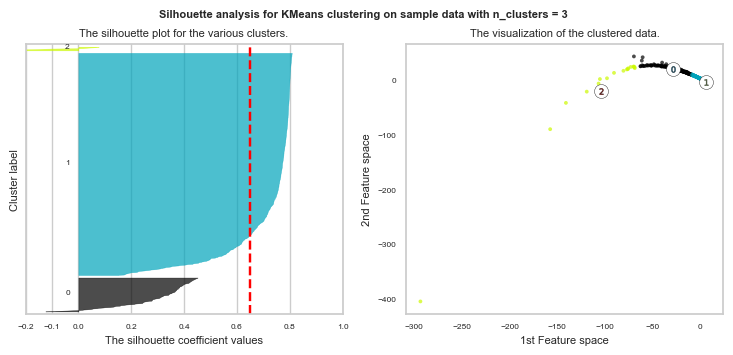

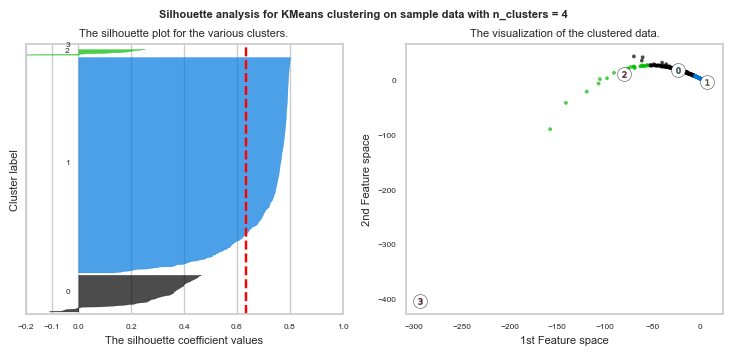

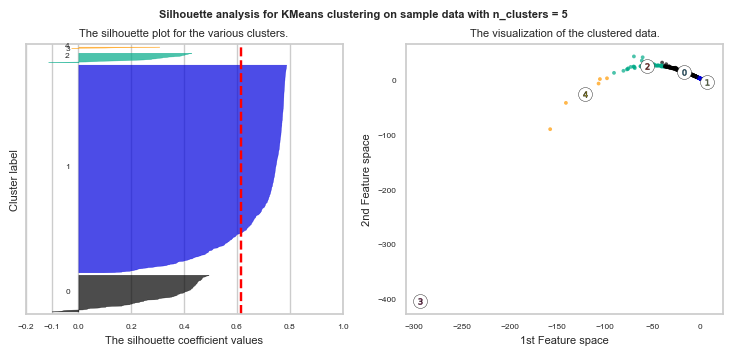

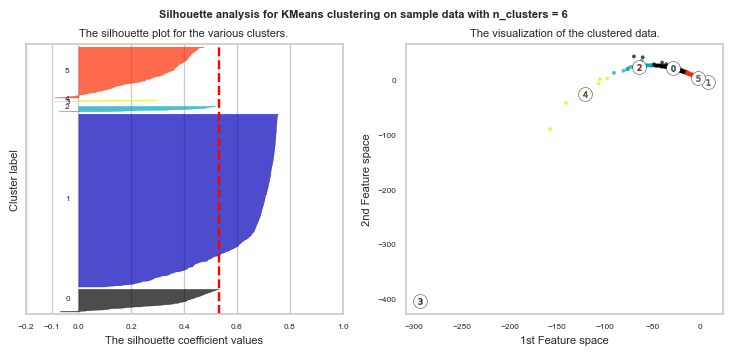

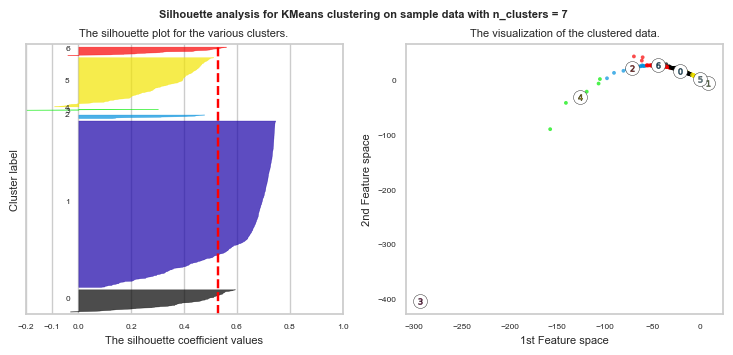

In [181]:
range_n_clusters = [3, 4, 5, 6, 7]

for n_clusters in range_n_clusters:

# Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(9, 3.5))
    #fig.set_size_inches(10, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_pca) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_pca)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize = 6)

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.tick_params(axis='y', labelsize=6)
    ax1.set_xticks([-0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    ax1.tick_params(axis='x', labelsize=6)

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X_pca[:, 0], X_pca[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=100,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=20, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("1st Feature space")
    ax2.set_ylabel("2nd Feature space")
    ax2.grid(False)
    

    plt.rcParams['axes.titlesize'] = 8
    plt.rcParams['axes.labelsize'] = 8
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    
    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=8,
        fontweight="bold",
    )

plt.show()

Elbow Method

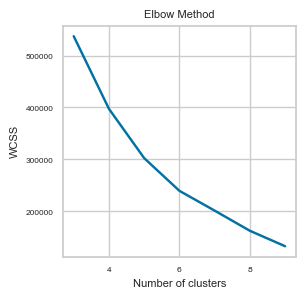

In [182]:
# Finding the optimal number of clusters using Elbow Method
wcss = []
for i in range(3, 10):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(3, 3)) 
plt.plot(range(3, 10), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.show()

## TD-IDF Encoded

Standardizing Features

In [183]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_TD_enc)

Dimensionality Reduction using Principal Component Analysis

In [304]:
# Perform PCA
pca = PCA(n_components=14)
X_pca = pca.fit_transform(X_scaled)

# Calculate the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

c_sum = np.cumsum(explained_variance_ratio)
pc_components = np.arange(pca.n_components_) + 1
c_sum_df = pd.DataFrame(zip(pc_components, c_sum), columns=['Principal Component', 'Cummulative Explained Variance'])
c_sum_df

,Principal Component,Cummulative Explained Variance
0,1,0.218082
1,2,0.334158
2,3,0.405615
3,4,0.455115
4,5,0.498417
5,6,0.539339
6,7,0.577508
7,8,0.606221
8,9,0.632655
9,10,0.656617


Scree Plot - to Analyze Optimal PCA Components

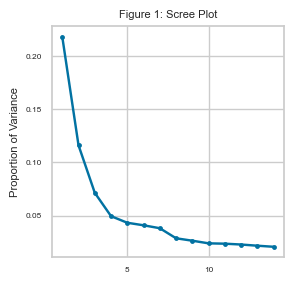

In [378]:
plt.figure(figsize=(3, 3)) 
plt.plot(pc_components, 
         explained_variance_ratio, 
         'b.-')
plt.title('Figure 1: Scree Plot', fontsize=8)
plt.ylabel('Proportion of Variance', fontsize=8)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.show()

In [433]:
# kmeans code
kmeans = KMeans(init = 'k-means++', n_clusters=10, n_init= 5, random_state = 10) 
km = kmeans.fit(X_pca) 
# km.n_iter_
# labels = km.labels_
labels = km.predict(X_pca)

In [434]:
# add cluster results to dataset
df_TD_enc['cluster'] = labels
df_TD_enc.head()

,gender,age,number_of_claims,G9829,G0155,G0153,G8946,99241,S0605,G0424,...,G0444,99221,S9131,T1021,H2000,S9126,G0300,G8111,G0156,cluster
0,0,71.0,14,0.0,0.000000,0.000000,0.000000,0.514347,0.0,0.0,...,0.845664,0.142479,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,0,74.0,32,0.0,0.236034,0.463790,0.000000,0.186238,0.0,0.0,...,0.078291,0.000000,0.247682,0.0,0.000000,0.000000,0.200633,0.000000,0.000000,1
2,0,77.0,25,0.0,0.078152,0.491405,0.000000,0.291506,0.0,0.0,...,0.230423,0.031058,0.328036,0.0,0.000000,0.000000,0.241567,0.000000,0.000000,1
3,1,76.0,110,0.0,0.045860,0.000000,0.063947,0.552649,0.0,0.0,...,0.054086,0.747218,0.000000,0.0,0.040371,0.000000,0.000000,0.102497,0.000000,9
4,0,79.0,56,0.0,0.233978,0.000000,0.000000,0.358044,0.0,0.0,...,0.045991,0.000000,0.000000,0.0,0.000000,0.340831,0.000000,0.069725,0.355888,2


In [435]:
# quick look at cluster values
vals = df_TD_enc['cluster'].value_counts(normalize=True) * 100
pd.DataFrame({
  'cluster': vals
}).head(12)

,cluster
cluster,
0,51.054482
1,22.847100
2,12.214411
5,9.050967
4,1.933216
3,1.230228
9,0.966608
8,0.351494
6,0.263620


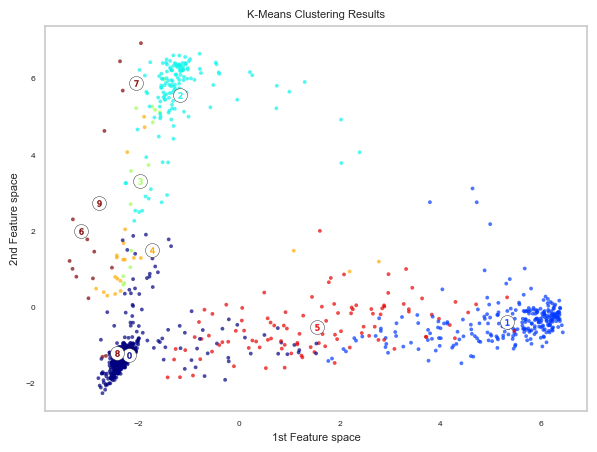

In [436]:
fig, ax = plt.subplots(figsize=(7, 5))
colors = cm.jet( (labels.astype(float) * 2) / (n_clusters))
ax.scatter(
        X_pca[:, 0], X_pca[:, 1], 
        marker=".", 
        s=30, 
        lw=0, 
        alpha=0.7, 
        color = colors,
        edgecolor="k"
    )

# Labeling the clusters
centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
ax.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=100,
        edgecolor="k",
    )

for i, c in enumerate(centers):
    ax.scatter(c[0], c[1], 
               marker="$%d$" % i, 
               alpha=1, s=20, 
               #edgecolor=cm.jet( 0.66729918)
               color = cm.jet( (i * 2) / (n_clusters)))
    ax.set_title("K-Means Clustering Results")
    ax.set_xlabel("1st Feature space")
    ax.set_ylabel("2nd Feature space")
    ax.grid(False)
    
    plt.rcParams['axes.titlesize'] = 8
    plt.rcParams['axes.labelsize'] = 8
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)

plt.show()

Calculate Silhouette Score

In [437]:
# works for all sklearn unsupervised model evaluation metrics with DBSCAN
score = silhouette_score(X_pca, km.labels_, metric='euclidean')
print('Silhouetter Score: %.3f' % score)

Silhouetter Score: 0.537


Create Silhouette Plot

For n_clusters = 7 The average silhouette_score is : 0.5071753796731102
For n_clusters = 8 The average silhouette_score is : 0.5315964106791631
For n_clusters = 9 The average silhouette_score is : 0.534218665446171
For n_clusters = 10 The average silhouette_score is : 0.5366215950193326
For n_clusters = 11 The average silhouette_score is : 0.5285489550307776


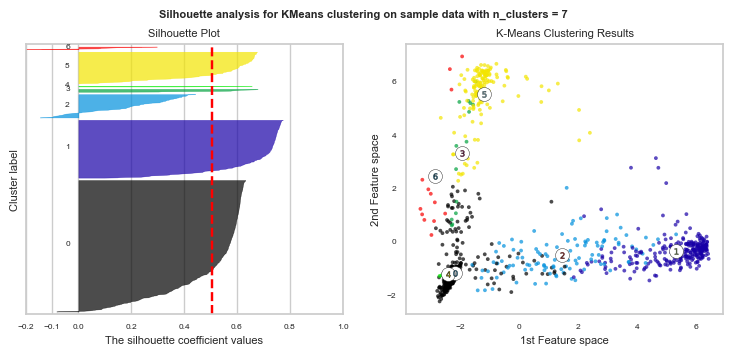

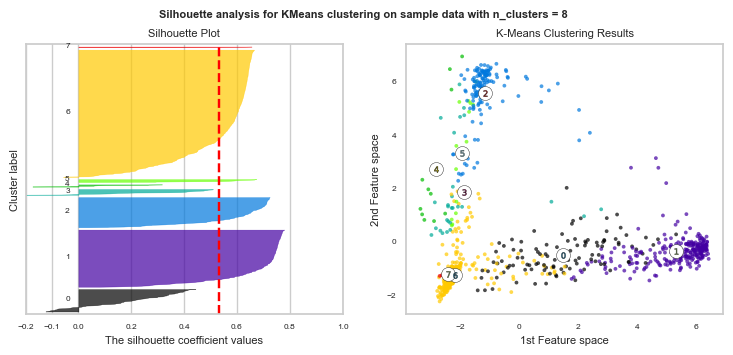

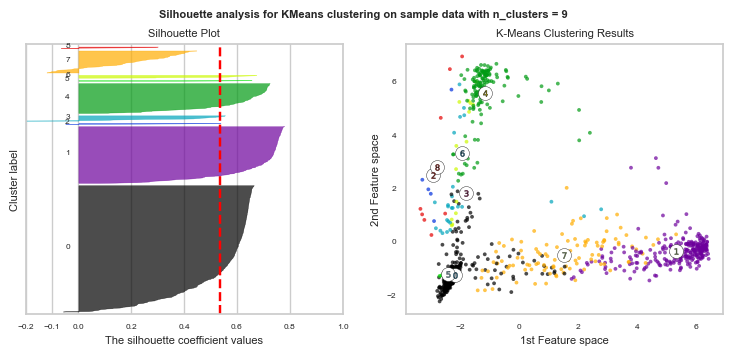

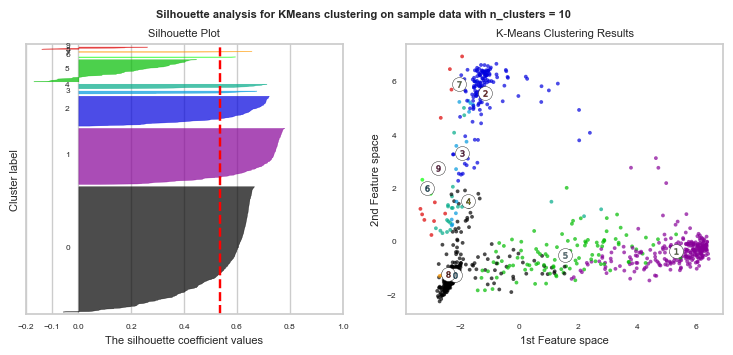

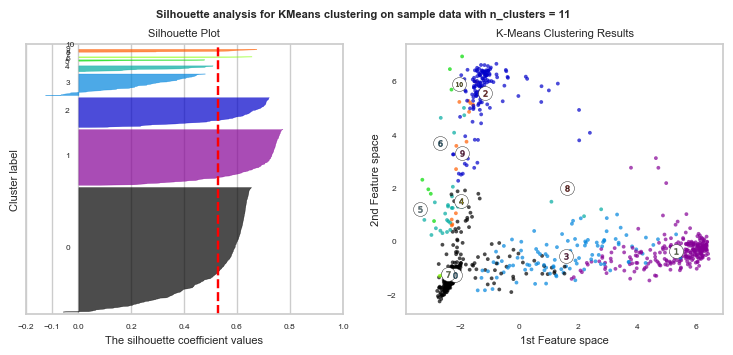

In [439]:
range_n_clusters = [7, 8, 9, 10, 11]

for n_clusters in range_n_clusters:

# Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(9, 3.5))
    #fig.set_size_inches(10, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_pca) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(init = 'k-means++', n_clusters=n_clusters, n_init = 15, random_state=10)
    cluster_labels = clusterer.fit_predict(X_pca)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize = 6)

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette Plot")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.tick_params(axis='y', labelsize=6)
    ax1.set_xticks([-0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    ax1.tick_params(axis='x', labelsize=6)

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X_pca[:, 0], X_pca[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=100,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=20, edgecolor="k")

    ax2.set_title("K-Means Clustering Results")
    ax2.set_xlabel("1st Feature space")
    ax2.set_ylabel("2nd Feature space")
    ax2.grid(False)
    

    plt.rcParams['axes.titlesize'] = 8
    plt.rcParams['axes.labelsize'] = 8
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    
    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=8,
        fontweight="bold",
    )

plt.show()

### Hierarchical Clustering

In [ ]:
# works for AgglomerativeClustering, FeatureAgglomerization and DBScan
from sklearn.cluster import AgglomerativeClustering
agg_clustering = AgglomerativeClustering(n_clusters=3)
labels = agg_clustering.fit_predict(X_train)


### Guassian Mixture

In [ ]:
# GMM code
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, random_state=0)
gmm.fit(X)
labels = gmm.predict(X_train)

Model Selection

In [ ]:
# example grid search

param_grid = {n_components: [2, 5, 8, 10]} # easily add another parameter to this structure

grid_search = GridSearchCV(
    estimator=KMeans(random_state=42, n_init='auto'),
    param_grid=param_grid,
    scoring=silhouette_scorer,
    n_jobs=-1
)

grid_search.fit(X)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

Visualizations:

word cloud 


In [217]:
df_patient = pd.read_pickle(f"{path}/patient_level.pkl")

In [ ]:
# merge primary diagnosis column back onto data now that it has been through learning
df_patient = df_patient[['patient_medicare_number', 'age', 'combined_principal_diagnosis_ls', 'combined_hcpcs_ls']]
# dropping data so the dataset is the same as the end dataset in 04_created_unsupervised_features
df_patient = df_patient[df_patient['age'].notnull()]
df_patient['ls_len'] = df_patient['combined_hcpcs_ls'].str.len()
df_patient = df_patient[df_patient['ls_len'] < 1000]
df_unsupervised = pd.concat([df_patient.reset_index(drop=True), df_TD_enc.reset_index(drop=True)], axis = 1)

In [222]:
df_unsupervised.tail()

,patient_medicare_number,age,combined_principal_diagnosis_ls,combined_hcpcs_ls,ls_len,gender,age,number_of_claims,G9829,G0155,...,G0444,99221,S9131,T1021,H2000,S9126,G0300,G8111,G0156,cluster
1133,1S00E00KM04,79.0,"[E785, E785, E785, E785, E785, E785, J0390, J0...","[99241, 99241, 99241, G0444, G9572, 99241, G04...",22,0,79.0,21,0.0,0.000000,...,0.313841,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,1
1134,1S00E00JD83,68.0,"[R739, R739, R739, R739, R739, R739, R739, R73...","[G0444, G0444, 99241, 99241, 99241, 99241, 992...",31,0,68.0,31,0.0,0.000000,...,0.456140,0.061481,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,1
1135,1S00E00JF65,79.0,"[B085, B085, B085, B085, B085, B085, B085, J02...","[G0444, G0444, 99241, 99241, G0444, 99241, 992...",101,0,79.0,28,0.0,0.232422,...,0.137054,0.036946,0.000000,0.0,0.000000,0.507847,0.000000,0.0,0.298284,2
1136,1S00E00JQ12,80.0,"[E785, J209, E785, E785, J329, J329, J329, J32...","[99241, 99241, 99241, 99241, 99241, 99241, 992...",204,0,80.0,27,0.0,0.124482,...,0.027527,0.012367,0.373215,0.0,0.000000,0.000000,0.250102,0.0,0.000000,5
1137,1S00E00HP38,74.0,"[E785, E785, E785, E785, E785, E785, E785, E78...","[99241, 99241, G0444, 99241, G0444, 99241, 992...",31,0,74.0,30,0.0,0.204738,...,0.362188,0.000000,0.122767,0.0,0.180231,0.000000,0.000000,0.0,0.145975,6


In [223]:
df_unsupervised['principal_unq'] = df_unsupervised['combined_principal_diagnosis_ls'].apply(lambda x: list(set(x)))

In [227]:
df_unsupervised.head()

,patient_medicare_number,age,combined_principal_diagnosis_ls,combined_hcpcs_ls,ls_len,gender,age,number_of_claims,G9829,G0155,...,S9131,T1021,H2000,S9126,G0300,G8111,G0156,cluster,principal_unq,word_cloud
0,1S00E00GA44,71.0,"[J029, E669, J029, E669, J029, J029, J029]","[G0444, 99241, G0444, 99241, 99221, G0444, G04...",14,0,71.0,14,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1,"[E669, J029]",nan
1,1S00E00JN08,74.0,"[B085, B349, E785, J209, J029, E785, E785, E78...","[G0444, 99241, 99241, G0444, 99241, 99241, 992...",217,0,74.0,32,0.0,0.236034,...,0.247682,0.0,0.000000,0.000000,0.200633,0.000000,0.000000,5,"[E785, J209, B349, J029, J329, B085, J0190]",nan
2,1S00E00HT71,77.0,"[E785, O039, E785, B002, E785, O039, E785, E78...","[G0444, 99241, G0402, Q5001, S9131, G0300, G01...",87,0,77.0,25,0.0,0.078152,...,0.328036,0.0,0.000000,0.000000,0.241567,0.000000,0.000000,5,"[E785, B002, S46029, S46019, O039]",nan
3,1S00E00MW82,76.0,"[B953, B953, B953, B953, B953, B953, B953, B95...","[99241, 99241, 99241, 99241, 99241, 99241, 992...",111,1,76.0,110,0.0,0.045860,...,0.000000,0.0,0.040371,0.000000,0.000000,0.102497,0.000000,8,"[E785, B349, J329, B085, B953, J0190, E669, C5...",nan
4,1S00E00GE68,79.0,"[I639, C50929, C50919, C50919, C50919, C50919,...","[99241, S8075, 99241, 99241, G0444, S8075, 992...",160,0,79.0,56,0.0,0.233978,...,0.000000,0.0,0.000000,0.340831,0.000000,0.069725,0.355888,2,"[J209, J029, J329, J0390, C50919, I639, C50929]",nan


In [293]:
# create work cloud column of diagnosis descriptions

for index, row in df_unsupervised.iterrows():

    #print(row['principal_unq'])
    if len(row['principal_unq']) > 1:
        row_ls = []
        for code in row['principal_unq']:
            #print(code)
            if icd10_mapper['CODE'].isin([code]).any():
                ind = icd10_mapper[icd10_mapper['CODE'].str.contains(code)].index[0].item()
                #print(ind)
                text = icd10_mapper.loc[ind, 'SHORT DESCRIPTION'].split(' ')[0:4]
                #print(f"text {text}") 
            #row_ls.append(text)
            #print(text)
            row_ls = row_ls + text
        #print(row_ls)
        #row_ls = [ word for word in row_ls if word != ',']
        row_ls = [ word.strip(", '") for word in row_ls if word.strip(", '") not in ['unspecified', 'Unspecified', 'unsp', 'the', 'as', 'of', 'or', 'w', 'w/o', 'in', 'Acute', 'Chronic', 'Essential', '(primary)']]
        #print(row_ls)
        df_unsupervised.at[index, 'word_cloud'] = str(set(row_ls))
        # df_unsupervised.at[index, 'word_cloud']= pd.Series([row_ls] * len(df_unsupervised))
        # df_unsupervised.assign(word_cloud =  [row_ls for i in df_unsupervised.index])

    else:
        #print(code)
        if icd10_mapper['CODE'].str.contains(code).any():
            ind = icd10_mapper[icd10_mapper['CODE'].str.contains(code)].index[0].item()
            #print(ind)
            text = icd10_mapper.loc[ind, 'SHORT DESCRIPTION'].split( )[0:4]
            text = [ word for word in text if word not in ['unspecified', 'Unspecified', 'as', 'of', 'or', 'w', 'w/o', 'Acute', 'Chronic', 'Essential', '(primary)']]
            print(f"text {text}")
            df_unsupervised.at[index, 'word_cloud'] = str(set(text))

text ['Urinary', 'tract', 'infection,', 'site']
text ['Neonatal', 'hypertension']
text ['Cerebral', 'infarction,']
text ['tubal', 'pregnancy', 'without']
text ['sinusitis,']
text ['sinusitis,']
text ['bronchitis,']
text ['Urinary', 'tract', 'infection,', 'site']
text ['Sprain', 'ligaments']
text ['Complete', 'unsp', 'spontaneous']
text ['sinusitis,']
text ['hypertension']
text ['sinusitis,']
text ['Obesity,']
text ['sinusitis,']
text ['sinusitis,']
text ['Malignant', 'neoplasm', 'rectum']
text ['Viral', 'infection,']
text ['Left', 'ventricular', 'failure,']
text ['Anemia,']
text ['Anemia,']
text ['Sprain', 'ligaments']
text ['sinusitis,']
text ['Strain', 'musc/tend', 'the']
text ['Concussion', 'loss']
text ['Obesity,']
text ['sinusitis,']
text ['Emphysema,']
text ['Polyp', 'colon']


In [296]:
# Percentage breakdown
vals = df_unsupervised['word_cloud'].value_counts(normalize=True) * 100
pd.DataFrame({
  'age_breakdown': vals
}).head(5)

,age_breakdown
word_cloud,
"{'bronchitis', 'Hyperlipidemia', 'sinusitis'}",1.054482
"{'Hyperlipidemia', 'sinusitis'}",0.790861
"{'sinusitis,'}",0.702988
"{'agents', 'viral', 'sinusitis', 'Oth'}",0.615114
"{'infection', 'Viral', 'Hyperlipidemia'}",0.527241


In [288]:
df_unsupervised.tail()

,patient_medicare_number,age,combined_principal_diagnosis_ls,combined_hcpcs_ls,ls_len,gender,age,number_of_claims,G9829,G0155,...,S9131,T1021,H2000,S9126,G0300,G8111,G0156,cluster,principal_unq,word_cloud
1133,1S00E00KM04,79.0,"[E785, E785, E785, E785, E785, E785, J0390, J0...","[99241, 99241, 99241, G0444, G9572, 99241, G04...",22,0,79.0,21,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,1,"[E785, J0390, J0190]","{'sinusitis,', 'tonsillitis,', 'Acute', 'Hyper..."
1134,1S00E00JD83,68.0,"[R739, R739, R739, R739, R739, R739, R739, R73...","[G0444, G0444, 99241, 99241, 99241, 99241, 992...",31,0,68.0,31,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,1,"[R739, J209, J329]","{'bronchitis,', 'sinusitis,', 'Hyperglycemia,'..."
1135,1S00E00JF65,79.0,"[B085, B085, B085, B085, B085, B085, B085, J02...","[G0444, G0444, 99241, 99241, G0444, 99241, 992...",101,0,79.0,28,0.0,0.232422,...,0.000000,0.0,0.000000,0.507847,0.000000,0.0,0.298284,2,"[J209, J029, J329, B085, F0280, E669]","{'bronchitis,', 'sinusitis,', 'Dem', 'in', 'di..."
1136,1S00E00JQ12,80.0,"[E785, J209, E785, E785, J329, J329, J329, J32...","[99241, 99241, 99241, 99241, 99241, 99241, 992...",204,0,80.0,27,0.0,0.124482,...,0.373215,0.0,0.000000,0.000000,0.250102,0.0,0.000000,5,"[E785, J209, S8290X, J329, K635]","{'bronchitis,', 'sinusitis,', 'Hyperlipidemia,..."
1137,1S00E00HP38,74.0,"[E785, E785, E785, E785, E785, E785, E785, E78...","[99241, 99241, G0444, 99241, G0444, 99241, 992...",31,0,74.0,30,0.0,0.204738,...,0.122767,0.0,0.180231,0.000000,0.000000,0.0,0.145975,6,[E785],"{'colon', 'Polyp'}"


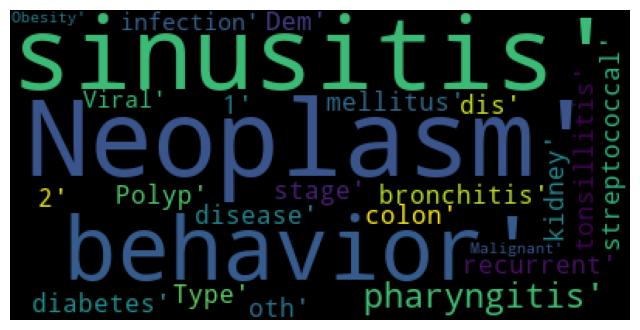

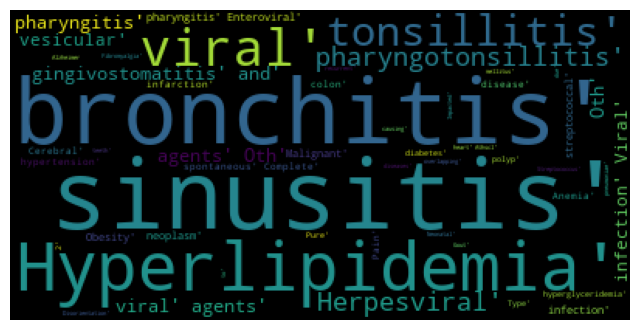

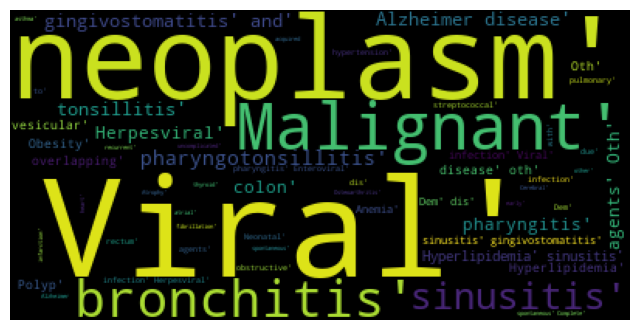

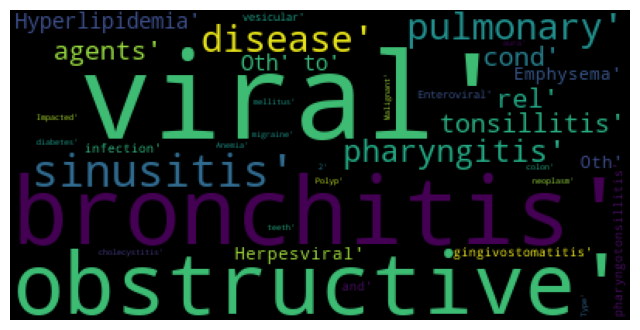

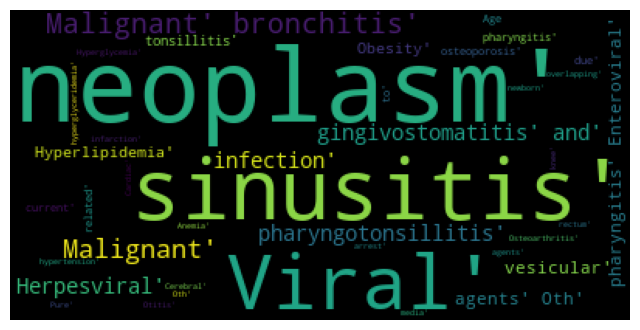

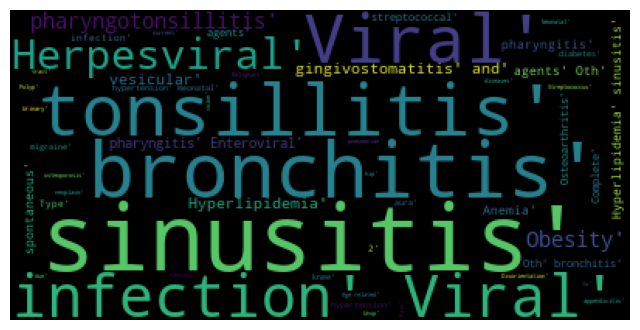

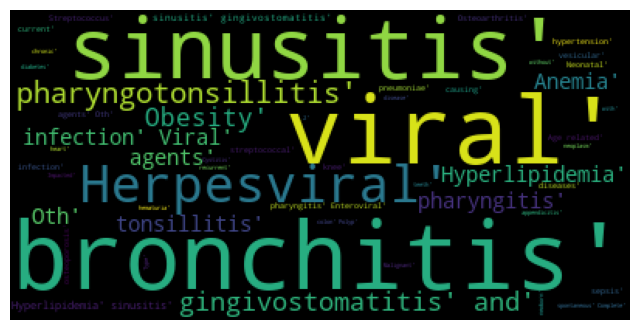

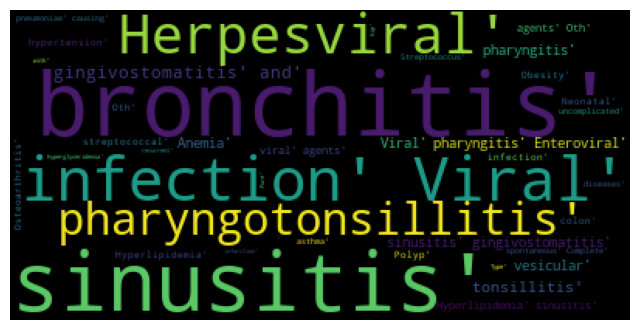

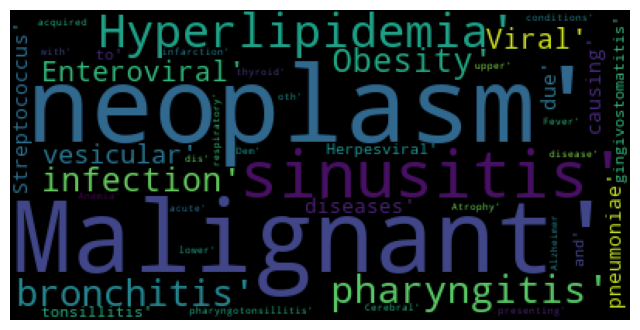

In [294]:
n_clusters = 9
for cluster in range(0,n_clusters):
    df_cluster = df_unsupervised[df_unsupervised['cluster'] == cluster]
    diag_cloud = df_cluster['word_cloud'].head(100).apply(str).str.cat(sep=', ')
    #Instantiate wordcloud object and use method to feed it our corpus
    wc = WordCloud().generate_from_text(diag_cloud)

    #Use matplotlib.pyplot to display the fitted wordcloud
    #Turn axis off to get rid of axis numbers
    plt.imshow(wc)
    plt.axis('off')
    plt.show()